In [1]:
!pip install kmodes

^C


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes, matching_dissim, euclidean_dissim
from sklearn.base import clone
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score, DistanceMetric
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy.spatial.distance import jaccard, pdist, squareform, dice

In [2]:
def GowerDistance(data, numColNames):
    gowerDist = np.zeros((len(data), len(data)))
    for col in data.columns:
        if col in numColNames:
            d_mat = DistanceMetric.get_metric('manhattan').pairwise(data[[col]]) / max(np.ptp(data[col]), 1)
            gowerDist += d_mat
        else:
            d_mat = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(data[col]))
            gowerDist += d_mat
    gowerDist = gowerDist / len(data.columns)
    return gowerDist

def ClusterStability(X, est, n_iter=30, seed=123, **kwargs):
    rng = np.random.RandomState(seed)
    labels = []
    idxs = []
    sils = []
    for i in range(n_iter):
        sample_idx = rng.randint(0, X.shape[0], X.shape[0])
        idxs.append(sample_idx)
        est = clone(est)
        if hasattr(est, "random_state"):
            est.random_state = rng.randint(1e5)
        try:
            X_boot = X[sample_idx, ]
        except:
            X_boot = X.iloc[sample_idx, ]
        pred_labels = est.fit_predict(X_boot, **kwargs)
        relabel = -np.ones(X.shape[0], dtype=int)
        relabel[sample_idx] = pred_labels
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, idxs):
        for k, j in zip(labels, idxs):
            if (i == j).all():
                continue
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

def calcKProtoDist(a, b, catColsIdx, numColsIdx):
    a_cat = a[catColsIdx].to_numpy().reshape(1, -1)
    b_cat = b[catColsIdx].to_numpy().reshape(1, -1)
    a_num = a[numColsIdx].to_numpy().reshape(1, -1)
    b_num = b[numColsIdx].to_numpy().reshape(1, -1)
    
    cat_dist = matching_dissim(a_cat, b_cat)
    num_dist = euclidean_dissim(a_num, b_num)
    return cat_dist, num_dist

def kProtoDistMat(data, catColsIdx, numColsIdx):
    nRows = len(data)
    scaler = MinMaxScaler()
    data_scale = data.copy()
    data_scale.iloc[:, numColsIdx] = scaler.fit_transform(data_scale.iloc[:, numColsIdx])
    catDistMat = np.zeros((nRows, nRows))
    numDistMat = catDistMat.copy()
    for i in range(nRows):
        for j in range(i, nRows):
            if i == j:
                continue
            a = data_scale.iloc[i]
            b = data_scale.iloc[j]
            cat_dist, num_dist = calcKProtoDist(a, b, catColsIdx, numColsIdx)
            catDistMat[i, j], catDistMat[j, i] = cat_dist, cat_dist
            numDistMat[i, j], numDistMat[j, i] = num_dist, num_dist
    return catDistMat, numDistMat
    
        

In [4]:
df1 = pd.read_csv('A:\\shared\\P428\\Datasets\\train_data_07152023.csv')
df2 = pd.read_csv('A:\\shared\\P428\\Datasets\\test_data_07152023.csv')
df = df1.drop(['Unnamed: 0', 'Treatment', 'Endpoint', 'ID', 'LipidLoweringAgents', 'AntihypertensiveAgents'], axis=1)
reDict = {'H': 1, 'B': 2, 'W': 3, 'O':4}
bmiDict = {'under': 1, 'normal': 2, 'over': 3, 'obese': 4}
df['RaceEthnicity'] = df['RaceEthnicity'].map(reDict)
df['BMI'] = df['BMI'].map(bmiDict)
X = df.dropna()
numCols = ['Age', 'SBP', 'DBP', 'AbdCirc', 'AvgDominantGrpStr', 
           'AvgGaitSpd', 'HDL_mmolL', 'LDL_mmolL', 'eGFR_CKD', 
           'Hgb', 'X3MS_Overall', 'CESD_Overall']
catColsIdx = [i for i, j in enumerate(X.columns) if j not in numCols]
numColsIdx = [i for i, j in enumerate(X.columns) if j in numCols]
gowerDist = GowerDistance(X, numCols)
catKProtoDist, numKProtoDist = kProtoDistMat(X, catColsIdx, numColsIdx)
X.head()

,Age,Gender,RaceEthnicity,LivingSituation,Education,BMI,SBP,DBP,AbdCirc,AvgDominantGrpStr,...,Frailty,FamHistHA,HistCancer,HDL_mmolL,LDL_mmolL,eGFR_CKD,Hgb,RegAspirin,X3MS_Overall,CESD_Overall
0,69.96,1,2,2,4,4.0,120,70,120.0,20.333333,...,1,1,1.0,0.9,2.4,40.533208,13.4,1,95,9
1,75.41,2,1,1,5,2.0,126,73,89.0,20.333333,...,1,0,0.0,1.5,3.7,71.611148,12.4,0,91,0
2,80.78,2,3,2,6,4.0,121,80,114.0,21.666667,...,1,0,0.0,1.3,3.1,81.228756,15.0,0,98,0
3,75.78,2,3,2,2,4.0,142,71,101.0,22.666667,...,1,1,0.0,1.2,2.8,71.429458,15.4,0,95,2
4,82.12,1,3,1,6,4.0,129,75,109.0,43.000000,...,0,1,0.0,1.2,3.7,62.354361,16.5,0,96,1


In [6]:
len(numColsIdx)

12

In [5]:
X_test = df2.drop(['Unnamed: 0', 'Treatment', 'Endpoint', 'ID', 'LipidLoweringAgents', 'AntihypertensiveAgents'], axis=1).dropna()
X_test['RaceEthnicity'] = X_test['RaceEthnicity'].map(reDict)
X_test['BMI'] = X_test['BMI'].map(bmiDict)
gowerTest = GowerDistance(X_test, numCols)
catKPDistTest, numKPDistTest = kProtoDistMat(X_test, catColsIdx, numColsIdx)

2 3 4 5 6 7 8 9 10 

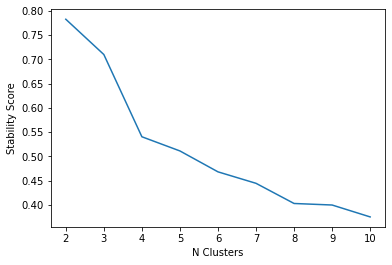

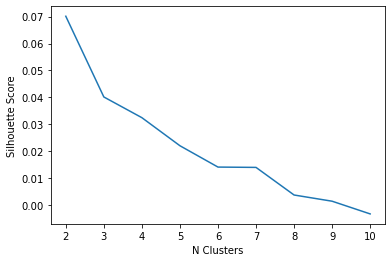

In [6]:
stabs = []
sils = []
for k in range(2, 11):
    print(k, end=' ')
    kp = KPrototypes(n_clusters=k, max_iter=30, n_init=3, init='random', n_jobs=-1)
    clusts = kp.fit_predict(X, categorical=catColsIdx)
    kpDists = catKProtoDist + numKProtoDist * kp.gamma
    stabs.append(ClusterStability(X, kp, categorical=catColsIdx))
    sils.append(silhouette_score(kpDists, clusts, metric='precomputed'))
plt.plot(range(2, 11), stabs)
plt.ylabel('Stability Score')
plt.xlabel('N Clusters')
plt.show()

plt.plot(range(2, 11), sils)
plt.ylabel('Silhouette Score')
plt.xlabel('N Clusters')
plt.show()

In [7]:
stabs[0]

0.7826874934295697

Silhouette Score: 0.08426345217775089


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


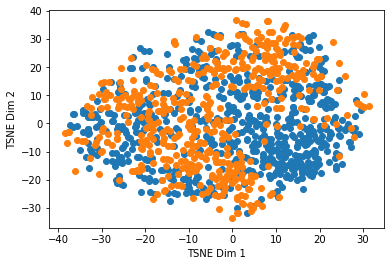

In [23]:
kp = KPrototypes(n_clusters=2)
clusts = kp.fit_predict(X_test, categorical=catColsIdx)
kpDists = catKPDistTest + numKPDistTest * kp.gamma
print(f"Silhouette Score: {silhouette_score(kpDists, clusts, metric='precomputed')}")

tsne_kp = TSNE(n_components=2, metric='precomputed')
tsne_res = tsne_kp.fit_transform(kpDists)

fig = plt.figure()
ax = fig.add_subplot()

tempDf = pd.DataFrame(np.hstack([tsne_res, clusts.reshape((-1, 1))]), columns=['dim1', 'dim2', 'clust'])
groups = tempDf.groupby('clust')
for val, group in groups:
    ax.plot(group['dim1'], group['dim2'], label=val, marker='o', linestyle='')
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
plt.show()

In [24]:
display(tempDf['clust'].value_counts())
kProtoClusts = df2.dropna()[['ID', 'Endpoint']]
kProtoClusts['Clusters'] = clusts
display(kProtoClusts.groupby('Clusters')['Endpoint'].sum()/kProtoClusts.groupby('Clusters')['Endpoint'].count())
kProtoClusts.to_csv('A:\\shared\\P428\\Edward_Clustering_DT\\KProtoGroups_07152023.csv', index=False)

0.0    661
1.0    489
Name: clust, dtype: int64

Clusters
0    0.081694
1    0.139059
Name: Endpoint, dtype: float64

2 3 4 5 6 7 8 9 10 

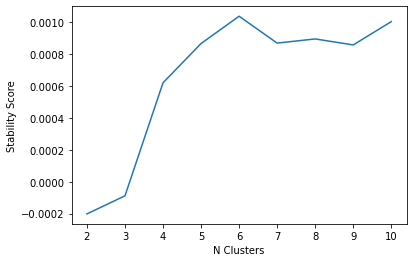

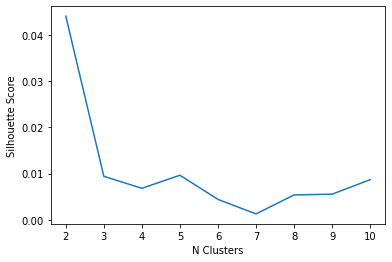

In [10]:
stabs = []
sils = []
for k in range(2, 11):
    print(k, end=' ')
    ac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete')
    clusts = ac.fit_predict(gowerDist)
    sils.append(silhouette_score(gowerDist, clusts, metric='precomputed'))
    stabs.append(ClusterStability(gowerDist, ac))
plt.plot(range(2, 11), stabs)
plt.ylabel('Stability Score')
plt.xlabel('N Clusters')
plt.show()

plt.plot(range(2, 11), sils)
plt.ylabel('Silhouette Score')
plt.xlabel('N Clusters')
plt.show()

In [13]:
stabs[3]

0.0008668912930876199

Silhouette Score: 0.016505938494498183


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


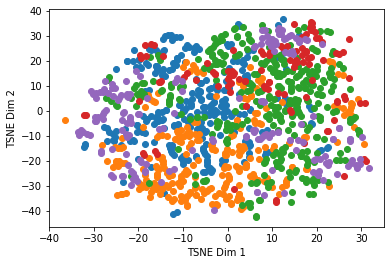

In [12]:
ac = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete')
clusts = ac.fit_predict(gowerTest)
print(f"Silhouette Score: {silhouette_score(gowerTest, clusts, metric='precomputed')}")

tsne_gower = TSNE(n_components=2, metric='precomputed')
tsne_res_gower = tsne_kp.fit_transform(gowerTest)

fig = plt.figure()
ax = fig.add_subplot()

tempDf = pd.DataFrame(np.hstack([tsne_res_gower, clusts.reshape((-1, 1))]), columns=['dim1', 'dim2', 'clust'])
groups = tempDf.groupby('clust')
for val, group in groups:
    ax.plot(group['dim1'], group['dim2'], label=val, marker='o', linestyle='')
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
plt.show()

In [14]:
maxSil = 0
bestDist = None
bestN = None
for dist in np.arange(0.005, 0.2, 0.005):
    for n in range(2, 16):
        db = DBSCAN(eps = dist, min_samples=n, metric='precomputed')
        clusts = db.fit_predict(gowerDist)
        clusts = np.delete(clusts, np.argwhere(clusts == -1))
        try:
            sil = silhouette_score(gowerDist, clusts, metric='precomputed')
            if sil > maxSil:
                maxSil = sil
                bestDist = dist
                bestN = n
        except:
            pass
print(maxSil, bestDist, bestN)

0 None None


In [15]:
db = DBSCAN(eps = 0.095, min_samples=2, metric='precomputed')
clusts = db.fit_predict(gowerDist)
print(silhouette_score(gowerDist, clusts, metric='precomputed'))
print(pd.Series(clusts).value_counts())

-0.3067212157604159
-1     875
 8      20
 22     14
 3      13
 6      11
      ... 
 2       2
 45      2
 46      2
 48      2
 85      2
Length: 87, dtype: int64


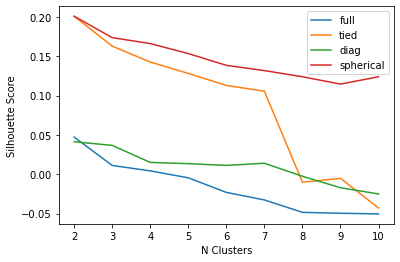

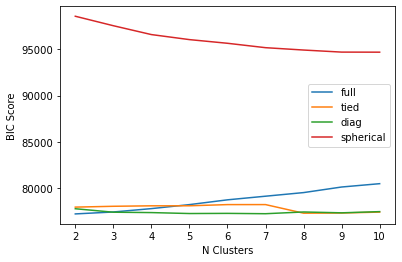

In [16]:
X_num = X.iloc[:, numColsIdx]

sils = {}
bics = {}

for cov_type in ['full', 'tied', 'diag', 'spherical']:
    sils[cov_type] = []
    bics[cov_type] = []
    for comps in range(2, 11):
        gm = GaussianMixture(covariance_type=cov_type, n_components=comps)
        clusts = gm.fit_predict(X_num)
        sils[cov_type].append(silhouette_score(X_num, clusts))
        bics[cov_type].append(gm.bic(X_num))

for key in sils:
    plt.plot(range(2, 11), sils[key], label=key)
    plt.ylabel('Silhouette Score')
    plt.xlabel('N Clusters')
plt.legend()
plt.show()
for key in bics:
    plt.plot(range(2, 11), bics[key], label=key)
    plt.ylabel('BIC Score')
    plt.xlabel('N Clusters')
plt.legend()
plt.show()

2 3 4 5 6 7 8 9 10 

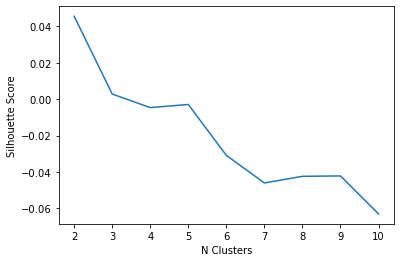

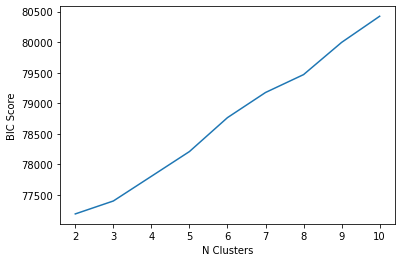

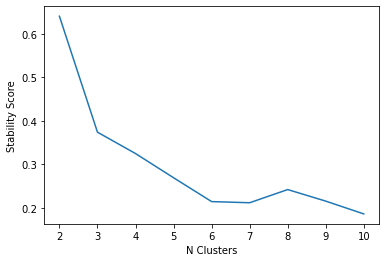

In [17]:
stabs = []
bics = []
sils = []

for k in range(2, 11):
    print(k, end=' ')
    gm = GaussianMixture(covariance_type='full', n_components=k)
    clusts = gm.fit_predict(X_num)
    stabs.append(ClusterStability(X_num, gm))
    sils.append(silhouette_score(X_num, clusts))
    bics.append(gm.bic(X_num))
plt.plot(range(2, 11), sils)
plt.ylabel('Silhouette Score')
plt.xlabel('N Clusters')
plt.show()

plt.plot(range(2, 11), bics)
plt.ylabel('BIC Score')
plt.xlabel('N Clusters')
plt.show()

plt.plot(range(2, 11), stabs)
plt.ylabel('Stability Score')
plt.xlabel('N Clusters')
plt.show()

In [18]:
stabs[0]

0.6407397198553813

Silhouette Score: 0.02781864735219432


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


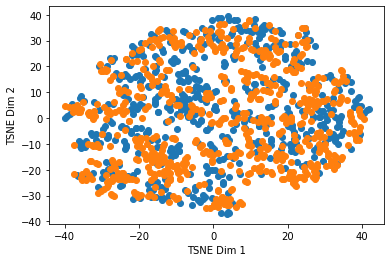

In [19]:
X_test_num = X_test.iloc[:, numColsIdx]
gmm = GaussianMixture(covariance_type='full', n_components=2)
clusts = gmm.fit_predict(X_test_num, clusts)
print(f"Silhouette Score: {silhouette_score(X_test_num, clusts)}")

tsne_num = TSNE(n_components=2)
tsne_res_num = tsne_num.fit_transform(X_test_num)

fig = plt.figure()
ax = fig.add_subplot()

tempDf = pd.DataFrame(np.hstack([tsne_res_num, clusts.reshape((-1, 1))]), columns=['dim1', 'dim2', 'clust'])
groups = tempDf.groupby('clust')
for val, group in groups:
    ax.plot(group['dim1'], group['dim2'], label=val, marker='o', linestyle='')
ax.set_xlabel('TSNE Dim 1')
ax.set_ylabel('TSNE Dim 2')
plt.show()